In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import random
import seaborn as sns
#import matplotlib as mpl
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
# Random seed for reproducibility
seed = 1

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
# Utility function to create folders and callbacks for training
from datetime import datetime

exp_dir = ''

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%Y-%m-%d_%H:%M')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tfk.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp'),
                                                save_weights_only=False,
                                                save_best_only=False)
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                               profile_batch=0,
                                               histogram_freq=1)
  callbacks.append(tb_callback)

In [4]:
#!unzip ANN_HW1.zip
#import zipfile
#with zipfile.ZipFile("dataset.zip", 'r') as z:
#    z.extractall()

In [5]:
# Set the path to the dataset 

dataset_dir = '../input/homework1-split/'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

In [6]:
# Plot example images from dataset
'''
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
    if i < len(labels):
        class_imgs = next(os.walk('{}/{}/'.format(training_dir, labels[i])))[2]
        class_img = class_imgs[0]
        img = Image.open('{}/{}/{}'.format(training_dir, labels[i], class_img))
        ax = axes[i//num_col, i%num_col]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()
'''

"\nlabels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']\n\nnum_row = len(labels)//2\nnum_col = len(labels)//num_row\nfig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))\nfor i in range(len(labels)):\n    if i < len(labels):\n        class_imgs = next(os.walk('{}/{}/'.format(training_dir, labels[i])))[2]\n        class_img = class_imgs[0]\n        img = Image.open('{}/{}/{}'.format(training_dir, labels[i], class_img))\n        ax = axes[i//num_col, i%num_col]\n        ax.imshow(np.array(img))\n        ax.set_title('{}'.format(labels[i]))\nplt.tight_layout()\nplt.show()\n"

In [7]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_gen = ImageDataGenerator(rotation_range=30,
                              height_shift_range=50,
                              width_shift_range=50,
                              zoom_range=0.3,
                              horizontal_flip=True,
                              vertical_flip=True, 
                              fill_mode='reflect',
                              preprocessing_function=preprocess_input)
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method

train_dataset = train_gen.flow_from_directory(directory=training_dir,
                                                target_size=(256,256),
                                                color_mode='rgb',
                                                classes=None,
                                                batch_size=8,
                                                shuffle=True,
                                                class_mode='categorical',
                                                seed=seed)


valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input)   

validation_dataset = valid_gen.flow_from_directory(directory=validation_dir,
                                                target_size=(256,256),
                                                color_mode='rgb',
                                                classes=None,
                                                batch_size=8,
                                                shuffle=True,
                                                class_mode='categorical',
                                                seed=seed)

Found 14176 images belonging to 14 classes.
Found 3552 images belonging to 14 classes.


In [8]:
input_shape = (256, 256, 3)
epochs = 150
model_name = 'vgg_aug_nodrop'

In [9]:
def build_model(input_shape):
#create model

    vgg = tfk.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Freeze the layers except the last convolutional block
    for layer in vgg.layers[:-4]:
        layer.trainable = False

    model = tfk.Sequential()
    model.add(vgg)
    model.add(tfk.layers.Flatten())
    model.add(tfkl.Dense(512, 
                         activation='relu',
                         kernel_regularizer=tfk.regularizers.l2(0.001),
                         kernel_initializer=tfk.initializers.GlorotUniform(seed)))
    model.add(tfkl.Dense(256,
                         activation='relu',  
                         kernel_regularizer=tfk.regularizers.l2(0.001),
                         kernel_initializer=tfk.initializers.GlorotUniform(seed)))
    model.add(tfkl.Dense(14, activation='softmax'))

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), 
                  optimizer=tfk.optimizers.Adam(0.0001), metrics='accuracy')

    # Return the model
    return model

2021-11-22 19:47:48.399671: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-22 19:47:48.402943: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 14)                3598      
                                                                 
Total params: 31,627,342
Trainable params: 23,992,078
Non-trainable params: 7,635,264
_________________________________________________________________


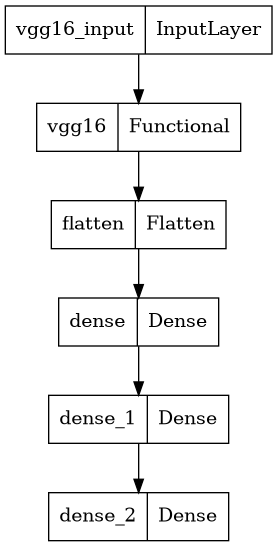

In [10]:
model = build_model(input_shape)
model.summary()
tfk.utils.plot_model(model)

In [11]:
callbacks = create_folders_and_callbacks(model_name=model_name)

# Train the model
history = model.fit(
    x = train_dataset,
    epochs = epochs,
    batch_size = 256,
    validation_data = validation_dataset,
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/150
  12/1772 [..............................] - ETA: 2:33:45 - loss: 3.8093 - accuracy: 0.2917

KeyboardInterrupt: 

In [ ]:
# Save the model
model.save(os.path.join(exp_dir, model_name))

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Predict the test set with the CNN
predictions = model.predict(valid_gen)

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(valid_gen.classes, np.argmax(predictions, axis=-1))

#Compute the classification metrics
accuracy = accuracy_score(valid_gen.classes, np.argmax(predictions, axis=-1))
precision = precision_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm.T, xticklabels=list(valid_gen.class_indices), yticklabels=list(valid_gen.class_indices))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()